<a href="https://colab.research.google.com/github/gracecarrillo/Political-Data-Science/blob/master/Model_Deployment_Sentiment_Analysis_Scotref2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scottish independence: Twitter data Sentiment Analysis



### 7.  Testing in real production environment 
  - Visualisation of twitter test data
  - Predictions on twitter data
  - Geospatial analysis and visualisation
  - Conclusion and final thoughts

In [0]:
# Must be upgraded
# Requires restart runtime
!pip install tqdm==4.36.1 --upgrade

In [0]:
# For geoplot
# Requires restart runtime
! apt-get install libgeos-3.5.0
! apt-get install libgeos-dev
! pip install https://github.com/matplotlib/basemap/archive/master.zip

In [0]:
# This goes before installing geoplot
!apt-get install libproj-dev proj-data proj-bin
!pip install cython
!pip install cartopy

In [0]:
!pip install geoplot

In [0]:
!pip install tweet_parser

In [0]:
!pip install --upgrade gensim

In [0]:
!pip install vaderSentiment

In [0]:
!pip install pygeocoder

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Evaluation
from numpy import loadtxt
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# For geoplots and twitter testing
import torch
import pickle
from keras.preprocessing.text import text_to_word_sequence
from IPython.display import IFrame
import folium
from folium import plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime
import networkx
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors

# set plot preferences
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 200) 

# hide warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported')
%matplotlib inline
%tensorflow_version 1.x

Libraries imported


### 7.1 Visualisation of twitter test data

Let's do some preprocessing to do some visualisations

In [0]:
# Helper functions to load SVM model from file

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [0]:
# Pipeline like preprocessing with helper functions

nltk.download('stopwords')
stop_words = stopwords.words('english')

# cleaning helper function
def processTweet(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Removes links, special characters and other bulk cleaning
    2. Returns a list of the tidy text
    """
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

# tokenize helper function
def text_process(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(tweet) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]

# Lexicon normalisation with Stemming 
def stemming(tokens):
  """
  Takes in a string of text, then performs the following:
  1. Replace words for its root based on orter Stemmer rule.
  2. Returns normalised text
   """
  stemmer = PorterStemmer()
  x = [stemmer.stem(w) for w in tokens]
   
  return ' '.join(x)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Load twitter data  
test = pd.read_csv('/content/drive/My Drive/Twitter_Project/df_indyref2.csv')

In [0]:
# Preprocessing
test['tidy_tweet'] = test['message'].apply(processTweet)

# Double check
test['tidy_tweet'] = test['tidy_tweet'].str.replace("[^a-zA-Z#]", " ") 

# tokenize tidy_tweet column and create a column for tokens
test['tokens'] = test['tidy_tweet'].apply(text_process) # tokenize

# Normalisation
stemmer = PorterStemmer() 
normalized_tweet = test['tokens'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

for i in range(len(normalized_tweet)):
    normalized_tweet[i] = ' '.join(normalized_tweet[i])    
test['tidy_tweet'] = normalized_tweet

test.drop(test.filter(regex="Unname"),axis=1, inplace=True)


In [0]:
list(test.columns)

['date',
 'user_loc',
 'message',
 'full_name',
 'country',
 'country_code',
 'geo_code',
 'tidy_tweet',
 'tokens']

#### Understanding the common words used in the tweets

Let's check out our most common words:

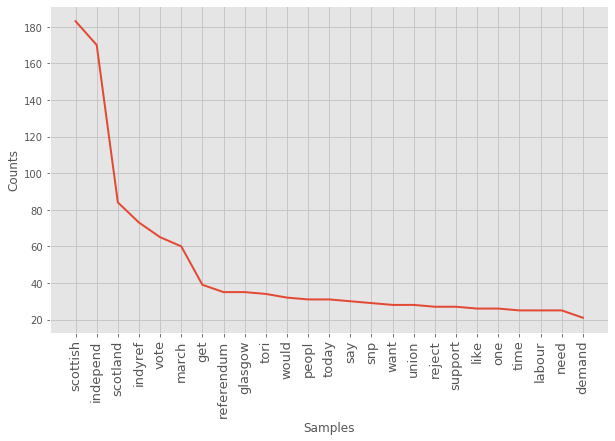

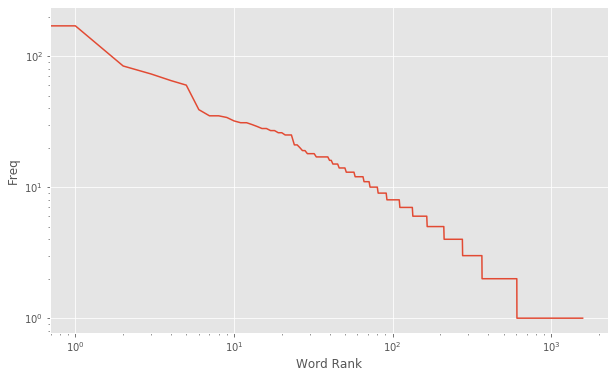

In [0]:
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

# most common words in twitter dataset
all_words = []
for line in list(test['tidy_tweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())

# plot word frequency distribution of first few words
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)

plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.savefig('/content/drive/My Drive/Twitter_Project/Most_Common_words.png', bbox_inches='tight')

As we can see, the words "indyref2", "scottish", "independent" and "scotland" are disproportionally common. So to create a word cloud depicting the most common words in the entire twitter dataset after normalisation, we should exclude them.


In [0]:
# helper function
def remove_words(word_list):
    remove = ['indyref2', 'indyref','scottish','...','“','”','’','…','independence', 'scotland']
    return [w for w in word_list if w not in remove]

# use previously tokenized column and create a column for tokens without key words
test = test.copy()
test['no_keywords'] = test['tokens'].apply(remove_words) # tokenize
test.head(3)

,date,user_loc,message,full_name,country,country_code,geo_code,tidy_tweet,tokens,no_keywords
0,2020-01-08 13:49:18,"Glasgow, Scotland",Can anyone in Scotland be arsed with this for another 5 years? Tories continue to shout down Scotland’s elected rep… https://t.co/xw8FDFOtwG,"Glasgow, Scotland",United Kingdom,GB,[-4.241751 55.858303],anyon scotland ars anoth year tori continu shout scotland elect rep,"[anyone, scotland, arsed, another, years, tories, continue, shout, scotland, elected, rep]","[anyone, arsed, another, years, tories, continue, shout, elected, rep]"
1,2020-01-08 13:59:26,"London, England",https://t.co/B6inPM8K8C\n\nThe Scottish Laa-Laas have IndyRef2 on their minds like they have been brainwashed by a religious cult.,"Hillingdon, London",United Kingdom,GB,[-0.442361 51.537061],scottish laa laa indyref mind like brainwash religi cult,"[scottish, laa, laas, indyref, minds, like, brainwashed, religious, cult]","[laa, laas, minds, like, brainwashed, religious, cult]"
2,2020-01-08 14:59:35,"Cardiff, Wales",@alcampian Scotlands best chance of independence is not any #indyref2 it's to ask the other 3 nations if they want… https://t.co/TZv4hynstr,"Cardiff, Wales",United Kingdom,GB,[-3.1798 51.497002],scotland best chanc independ ask nation want,"[scotlands, best, chance, independence, ask, nations, want]","[scotlands, best, chance, ask, nations, want]"


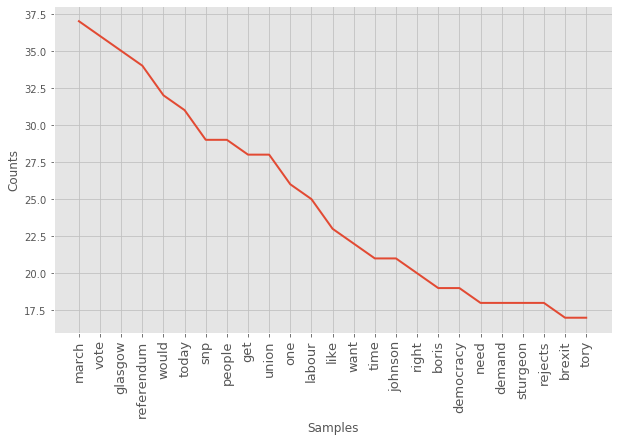

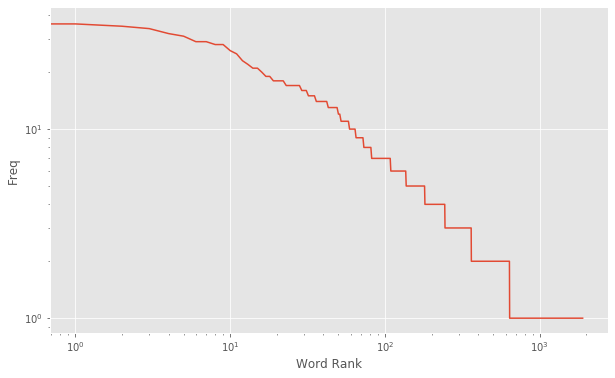

In [0]:
# plot word frequency distribution of first few words without keywords

no_keywords = []
for ls in test['no_keywords']:
    words = [w for w in ls]
    for word in words:
        no_keywords.append(word)

plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(no_keywords)
fd.plot(25,cumulative=False)

# log-log  of all words -- no_keywords 
word_counts = sorted(Counter(no_keywords).values(), reverse=True)
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

plt.savefig('/content/drive/My Drive/Twitter_Project/Most_Common_words_nokeywords.png', bbox_inches='tight')

I want to see how the words are distributed across the dataset. One way to accomplish this task is by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appears in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot, but without the disproportionately common keywords:

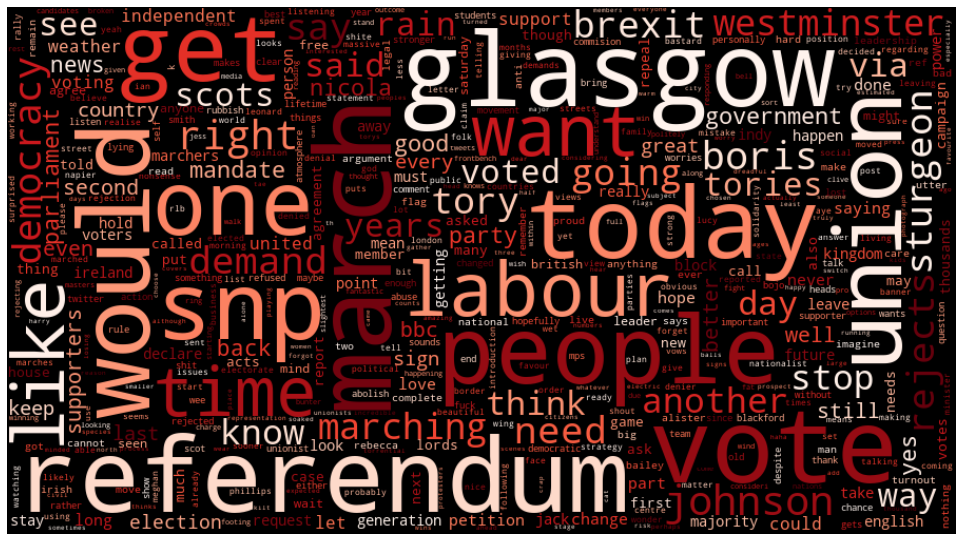

In [0]:
# split sentences to get individual words
all_words = []
for line in test['no_keywords']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Reds',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('/content/drive/My Drive/Twitter_Project/wordcloud.png', bbox_inches='tight')
plt.show()



We can see most of the words are pretty neutral. Words like "glasgow", "snp", "referendum", "people", "today", "union", "march" and "referendum" are the most frequent ones. It doesn’t give us any idea about the words associated with the negative or positive sentiment tweets.


### 7.2 Predictions on twitter data

We'll now use our trained model to create predictions of the tweets dataset. It is important to note that the model detects negative or positive sentiment in general. It does not detect if someone is tweeting something against or in favour of the subject in question. 

In [0]:
# Make a copy of original dataset
df_tweets=test.copy()
df_tweets.head(3)

,date,user_loc,message,full_name,country,country_code,geo_code,tidy_tweet,tokens,no_keywords
0,2020-01-08 13:49:18,"Glasgow, Scotland",Can anyone in Scotland be arsed with this for another 5 years? Tories continue to shout down Scotland’s elected rep… https://t.co/xw8FDFOtwG,"Glasgow, Scotland",United Kingdom,GB,[-4.241751 55.858303],anyon scotland ars anoth year tori continu shout scotland elect rep,"[anyone, scotland, arsed, another, years, tories, continue, shout, scotland, elected, rep]","[anyone, arsed, another, years, tories, continue, shout, elected, rep]"
1,2020-01-08 13:59:26,"London, England",https://t.co/B6inPM8K8C\n\nThe Scottish Laa-Laas have IndyRef2 on their minds like they have been brainwashed by a religious cult.,"Hillingdon, London",United Kingdom,GB,[-0.442361 51.537061],scottish laa laa indyref mind like brainwash religi cult,"[scottish, laa, laas, indyref, minds, like, brainwashed, religious, cult]","[laa, laas, minds, like, brainwashed, religious, cult]"
2,2020-01-08 14:59:35,"Cardiff, Wales",@alcampian Scotlands best chance of independence is not any #indyref2 it's to ask the other 3 nations if they want… https://t.co/TZv4hynstr,"Cardiff, Wales",United Kingdom,GB,[-3.1798 51.497002],scotland best chanc independ ask nation want,"[scotlands, best, chance, independence, ask, nations, want]","[scotlands, best, chance, ask, nations, want]"


In [0]:
df_tweets.dtypes

date            object
user_loc        object
message         object
full_name       object
country         object
country_code    object
geo_code        object
tidy_tweet      object
tokens          object
no_keywords     object
dtype: object

In [0]:
# Create data for predictions
tweets = df_tweets['message']

In [0]:
# convert to LSTM friendly format
tweet = df_tweets['message'].apply(processTweet)
nb_words = 10000  
tk = Tokenizer(num_words=nb_words) #tokenize
tk.fit_on_texts(tweet) #tokenize

# format your input for the neural net
tweets_seq = tk.texts_to_sequences(tweet) # integer encode
tweet_array = pad_sequences(tweets_seq, # good to use length it was trained on
                            maxlen=39) # Convert to 2-D Numpy array

In [0]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")

# load model
from keras.models import load_model
LSTM_model = load_model('/content/drive/My Drive/Twitter_Project/LSTM_model.h5')
# summarize model.
LSTM_model.summary()

Model: "LSTM model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 39, 128)           320000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 402       
Total params: 583,602
Trainable params: 583,602
Non-trainable params: 0
_________________________________________________________________


In [0]:
#--- Parameters----# 
batch_size = len(tweet_array)

# for human-friendly printing
labels = ['negative', 'positive']

# Predict and get output from the model
pred= LSTM_model.predict_classes(tweet_array, batch_size)

# append predictions to dataframe
df_tweets['predictions'] = pred
df_tweets.shape


(636, 16)

In [0]:
df_tweets.tail(5)

,date,user_loc,message,full_name,country,country_code,geo_code,tidy_tweet,tokens,no_keywords,predictions,word count,neg_scores,neu_scores,pos_scores,compound_scores
631,2020-01-15 19:07:45,"Manchester, England","@NicolaSturgeon Boris is my Hero, why don't you stop going on about indyref2 and sort out the problems in Scotland?","Cheadle, England",United Kingdom,GB,[-2.173983 53.36757 ],bori hero stop go indyref sort problem scotland,"['boris', 'hero', 'stop', 'going', 'indyref', 'sort', 'problems', 'scotland']","['boris', 'hero', 'stop', 'going', 'sort', 'problems']",1,20,0.363,0.370,0.267,-0.0772
632,2020-01-15 19:16:09,Perth Scotland,What now that BoJo has said No to a Scottish Independence Referendum? https://t.co/144JyNHisI via @BizforScotland,"Scotland, United Kingdom",United Kingdom,GB,[-4.200441 57.739454],bojo said scottish independ referendum via,"['bojo', 'said', 'scottish', 'independence', 'referendum', 'via']","['bojo', 'said', 'referendum', 'via']",0,15,0.000,1.000,0.000,0.0000
633,2020-01-15 19:22:09,NaN,Scottish independence.? I didn't vote in the 2014 I DEPENDANCE vote. I felt torn and didn't trust the snp. Independ… https://t.co/m7c71X5o6K,"Glasgow, Scotland",United Kingdom,GB,[-4.241751 55.858303],scottish independ vote depend vote felt torn trust snp independ,"['scottish', 'independence', 'vote', 'dependance', 'vote', 'felt', 'torn', 'trust', 'snp', 'independ']","['vote', 'dependance', 'vote', 'felt', 'torn', 'trust', 'snp', 'independ']",1,21,0.150,0.602,0.248,0.3182
634,2020-01-15 20:02:00,Scotland.,"@Femi_Sorry when we have our #indyref2, at our invitation would you campaign for #Scotland to be independent? #ScotlandsRightToChoose","Edinburgh, Scotland",United Kingdom,GB,[-3.203008 55.943196],invit would campaign independ,"['invitation', 'would', 'campaign', 'independent']","['invitation', 'would', 'campaign', 'independent']",0,18,0.000,1.000,0.000,0.0000
635,2020-01-15 20:02:23,s******d,"@kenmccoll @gilliecriosd They have all the print press except The National. They have the BBC, three British Natio… https://t.co/lM2z4UuuI5","Scotland, United Kingdom",United Kingdom,GB,[-4.200441 57.739454],print press except nation bbc three british natio,"['print', 'press', 'except', 'national', 'bbc', 'three', 'british', 'natio']","['print', 'press', 'except', 'national', 'bbc', 'three', 'british', 'natio']",1,19,0.000,1.000,0.000,0.0000


In [0]:
# check the number of positive vs. negative tagged sentences
# 0 — the polarity of the tweet (0 = negative, 4 = positive)
positives = df_tweets['predictions'][df_tweets.predictions == 1]
negatives = df_tweets['predictions'][df_tweets.predictions == 0]

print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(df_tweets.shape[0]))

number of positve tagged sentences is:  263
number of negative tagged sentences is: 373
total length of the data is:            636


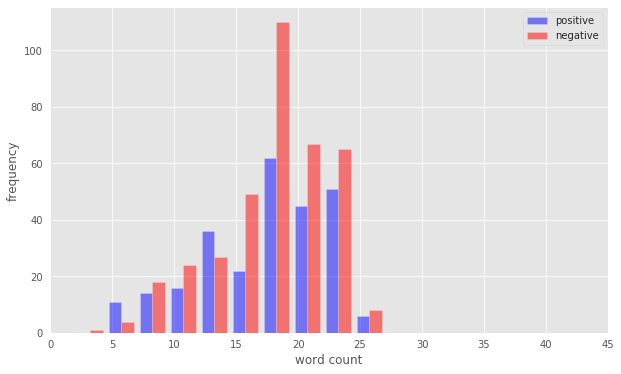

In [0]:
# plot word count distribution for both positive and negative sentiments
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 200) 

# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
df_tweets['word count'] = df_tweets['message'].apply(word_count)

x = df_tweets['word count'][df_tweets.predictions == 1]
y = df_tweets['word count'][df_tweets.predictions == 0]
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['b','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right');

We notice there's a higher number of tweets tagged as negative compared to tweets tagged as positive, particularly when the word count of the tweet is higher. The longer the tweet in our the data set, the most likely it is that it's negative.

Let's have a look at some tweets:

In [0]:
# Let’s check out a few positive/negative labelled tweets:
df_tweets[df_tweets['predictions'] == 0].head(5) # negative

,date,user_loc,message,full_name,country,country_code,geo_code,tidy_tweet,tokens,no_keywords,predictions,word count,neg_scores,neu_scores,pos_scores,compound_scores
3,2020-01-08 15:23:24,Scotland,I’m not surprised (in the slightest) that @BorisJohnson has refused @NicolaSturgeon’s request to hold #Indyref2. Bu… https://t.co/T5yl0Ev9PD,"Glasgow, Scotland",United Kingdom,GB,[-4.241751 55.858303],surpris slightest refus request hold,"['surprised', 'slightest', 'refused', 'request', 'hold']","['surprised', 'slightest', 'refused', 'request', 'hold']",0,17,0.000,1.000,0.0,0.0000
4,2020-01-08 15:44:58,Scotland+,"@anninnis @BBCPolitics Vote NO to stay in the EU they said in 2014. Things change, time for IndyRef2","Glasgow, Scotland",United Kingdom,GB,[-4.241751 55.858303],vote stay said thing chang time indyref,"['vote', 'stay', 'said', 'things', 'change', 'time', 'indyref']","['vote', 'stay', 'said', 'things', 'change', 'time']",0,18,0.000,1.000,0.0,0.0000
7,2020-01-08 17:22:41,"Dumfries, Scotland",But what confuses me is he said vote for him and elect a UK Tory Government to stop IndyRef2 and people did. Now he… https://t.co/gwgWwLvsWS,"Edinburgh, Scotland",United Kingdom,GB,[-3.203008 55.943196],confus said vote elect tori govern stop indyref peopl,"['confuses', 'said', 'vote', 'elect', 'tory', 'government', 'stop', 'indyref', 'people']","['confuses', 'said', 'vote', 'elect', 'tory', 'government', 'stop', 'people']",0,25,0.216,0.784,0.0,-0.2960
8,2020-01-08 18:00:20,Scotland,"@STVNews He hasn't rejected it, he has just given an opinion. Rejecting it would be officially responding to the Se… https://t.co/DGWUDxNt5e","Scotland, United Kingdom",United Kingdom,GB,[-4.200441 57.739454],reject given opinion reject would offici respond,"['rejected', 'given', 'opinion', 'rejecting', 'would', 'officially', 'responding']","['rejected', 'given', 'opinion', 'rejecting', 'would', 'officially', 'responding']",0,21,0.519,0.481,0.0,-0.6597
9,2020-01-08 18:01:01,"Lewisham, London",@JennThorburn_ @elsieortong @maliharez @SamMoore249 The Labour Party is a British party specifically; it can't advo… https://t.co/QfHXyLURhY,"Budapest, Hungary",Hungary,HU,[19.129828 47.48123 ],labour parti british parti specif advo,"['labour', 'party', 'british', 'party', 'specifically', 'advo']","['labour', 'party', 'british', 'party', 'specifically', 'advo']",0,16,0.000,1.000,0.0,0.0000


We observe that the tweets tagged as negative read a bit angry or upset, albeit depends on the reader's perspective.

In [0]:
df_tweets[df_tweets['predictions'] == 1].head(5) # positive

,date,user_loc,message,full_name,country,country_code,geo_code,tidy_tweet,tokens,no_keywords,predictions,word count,neg_scores,neu_scores,pos_scores,compound_scores
0,2020-01-08 13:49:18,"Glasgow, Scotland",Can anyone in Scotland be arsed with this for another 5 years? Tories continue to shout down Scotland’s elected rep… https://t.co/xw8FDFOtwG,"Glasgow, Scotland",United Kingdom,GB,[-4.241751 55.858303],anyon scotland ars anoth year tori continu shout scotland elect rep,"['anyone', 'scotland', 'arsed', 'another', 'years', 'tories', 'continue', 'shout', 'scotland', 'elected', 'rep']","['anyone', 'arsed', 'another', 'years', 'tories', 'continue', 'shout', 'elected', 'rep']",1,21,0.000,1.000,0.000,0.0000
1,2020-01-08 13:59:26,"London, England",https://t.co/B6inPM8K8C\n\nThe Scottish Laa-Laas have IndyRef2 on their minds like they have been brainwashed by a religious cult.,"Hillingdon, London",United Kingdom,GB,[-0.442361 51.537061],scottish laa laa indyref mind like brainwash religi cult,"['scottish', 'laa', 'laas', 'indyref', 'minds', 'like', 'brainwashed', 'religious', 'cult']","['laa', 'laas', 'minds', 'like', 'brainwashed', 'religious', 'cult']",1,18,0.000,0.762,0.238,0.3612
2,2020-01-08 14:59:35,"Cardiff, Wales",@alcampian Scotlands best chance of independence is not any #indyref2 it's to ask the other 3 nations if they want… https://t.co/TZv4hynstr,"Cardiff, Wales",United Kingdom,GB,[-3.1798 51.497002],scotland best chanc independ ask nation want,"['scotlands', 'best', 'chance', 'independence', 'ask', 'nations', 'want']","['scotlands', 'best', 'chance', 'ask', 'nations', 'want']",1,21,0.000,0.476,0.524,0.6705
5,2020-01-08 16:18:15,"Glasgow, Scotland",@CoyJudge Because that vote was done and lost so I moved on now we have Brexit which I was on the winning side of a… https://t.co/Uzgm92MVan,"Glasgow, Scotland",United Kingdom,GB,[-4.241751 55.858303],vote done lost move brexit win side,"['vote', 'done', 'lost', 'moved', 'brexit', 'winning', 'side']","['vote', 'done', 'lost', 'moved', 'brexit', 'winning', 'side']",1,26,0.207,0.450,0.342,0.3612
6,2020-01-08 17:13:18,NaN,"@pocket_rocket96 I’m Labour, on this I agree totally with Boris. SNP sort out all the shit they have created in Scotland. Indyref2 is dead.","Heswall, England",United Kingdom,GB,[-3.101829 53.335544],labour agre total bori snp sort shit creat scotland indyref dead,"['labour', 'agree', 'totally', 'boris', 'snp', 'sort', 'shit', 'created', 'scotland', 'indyref', 'dead']","['labour', 'agree', 'totally', 'boris', 'snp', 'sort', 'shit', 'created', 'dead']",1,24,0.467,0.533,0.000,-0.8360


Here we notice that some tweets are mislabeled. For example, tweet in row `6` sounds pretty negative but it has been tagged as positive sentiment. 

Our results could be benchmarked with other "out-of-the-box" sentiment analysis algorightms, like VaderSentiment, which we used during feature engineering. However, for the purposes of this project, we'll use our own trained model predictions. 

In [0]:
# Saving dataset with predictions
df_tweets.to_csv('/content/drive/My Drive/Twitter_Project/df_tweets_pred.csv', index=False)

### 7.3  Geospatial analysis

In this section we'll created geographic visualizations based from the downloaded tweets which is an important part of data storytelling.
<br>

While training any machine learning model is a big part the task, it's very important to be able to present our findings in ways that facilitate  understanding and decision making.
<br>

We'lluse the dataframe containing predictions and explore how they are distributed across Scotland but also across the UK nations since the tweets revolve around Scottish and UK news.
<br>

It's worth mentioning that there are limitations with our dataset going forward. The majority of tweeter users do not broadcast their geo location but our search criteria only pulled tweets that had some information that would allow us to get this geolocation.
<br>

It is therefore possible that we are missing a lot of geo tags that would paint a different picture than we come up with when plotted on a map. Knowing this is crucial in interpreting results but also but also understanding how we can make the model more robust.

### 7.1 Extract latitude and longitude of tweets

To plot the location of tweets, we will need to extract the latitde and longitude from the `geocode` variable in our dataset. However, this variable is saved as a string representation of a list. We will have to convert it into an actual list to be able to extract the latitude and longitude for geoplotting:

In [0]:
# Load dataset 
df_tweets = pd.read_csv('/content/drive/My Drive/Twitter_Project/df_tweets_pred.csv')

In [0]:
# Geocode values are stored as objects/strings
# And with different sized whitespace
df_tweets.geo_code.head(15)

0     [-4.241751 55.858303]
1     [-0.442361 51.537061]
2     [-3.1798   51.497002]
3     [-4.241751 55.858303]
4     [-4.241751 55.858303]
5     [-4.241751 55.858303]
6     [-3.101829 53.335544]
7     [-3.203008 55.943196]
8     [-4.200441 57.739454]
9     [19.129828 47.48123 ]
10    [19.129828 47.48123 ]
11    [-3.932982 56.13561 ]
12    [-4.241751 55.858303]
13    [-3.1798   51.497002]
14    [-3.203008 55.943196]
Name: geo_code, dtype: object

In [0]:
# Converting string representation of list to list using strip and split 
# Can't use json.loads() or ast.literal_eval() because there's no comma delimiter

#--- Test with one tweet ----#

ini_list = df_tweets.geo_code[14]

# Converting string to list,
# .strip(']['): remove whitespace characters at the beginning or end of []
# .split():  remove all whitespace in between characters

results = ini_list.strip('][').split() 

# previous code returns lon and lat values as strings
# i.e. ['-4.241751', '55.858303']
# So, we must convert string lon and lat to floats
results = list(map(float, results))

# printing final result and its type 
print ("final list", results) 
print (type(results))

final list [-3.203008, 55.943196]
<class 'list'>


In [0]:
# Extract tweets to list for preprocessing
lon_lat = df_tweets['geo_code']

In [0]:
#---------- Loop with all tweets ----------#

# Extract tweets to list for preprocessing
lon_lat = df_tweets['geo_code']

# Initialise empty list
final_list = []

for row in lon_lat:
  # Remove whitespace either side of [] and
  # remove all whitespace in between characters
  str_list = row.strip('][').split()

  # Convert string to float list
  float_list = list(map(float, str_list))

  # Append to final_list
  final_list.append(float_list)

#--- Check result ---#

final_list[:15]

[[-4.241751, 55.858303],
 [-0.442361, 51.537061],
 [-3.1798, 51.497002],
 [-4.241751, 55.858303],
 [-4.241751, 55.858303],
 [-4.241751, 55.858303],
 [-3.101829, 53.335544],
 [-3.203008, 55.943196],
 [-4.200441, 57.739454],
 [19.129828, 47.48123],
 [19.129828, 47.48123],
 [-3.932982, 56.13561],
 [-4.241751, 55.858303],
 [-3.1798, 51.497002],
 [-3.203008, 55.943196]]

In [0]:
# Overwrite original dataframe
df_tweets['geo_code'] = final_list

In [0]:
#------ Check result ------#
df_tweets['geo_code'].head(15)

0     [-4.241751, 55.858303]
1     [-0.442361, 51.537061]
2       [-3.1798, 51.497002]
3     [-4.241751, 55.858303]
4     [-4.241751, 55.858303]
5     [-4.241751, 55.858303]
6     [-3.101829, 53.335544]
7     [-3.203008, 55.943196]
8     [-4.200441, 57.739454]
9      [19.129828, 47.48123]
10     [19.129828, 47.48123]
11     [-3.932982, 56.13561]
12    [-4.241751, 55.858303]
13      [-3.1798, 51.497002]
14    [-3.203008, 55.943196]
Name: geo_code, dtype: object

In [0]:
# Extract latitudes and longitudes

# some helper funtions
def longs(x):
    return x[0]

def lats(x):
    return x[1]

# --------------------------------------------------------#
# append longs and lats to dframe
df_tweets['latitude'] = df_tweets['geo_code'].apply(lats)
df_tweets['longitude'] = df_tweets['geo_code'].apply(longs)
df_tweets.columns

Index(['date', 'user_loc', 'message', 'full_name', 'country', 'country_code',
       'geo_code', 'tidy_tweet', 'tokens', 'no_keywords', 'predictions',
       'word count', 'neg_scores', 'neu_scores', 'pos_scores',
       'compound_scores', 'latitude', 'longitude'],
      dtype='object')

In [0]:
df_tweets.head()

,date,user_loc,message,full_name,country,country_code,geo_code,tidy_tweet,tokens,no_keywords,predictions,word count,neg_scores,neu_scores,pos_scores,compound_scores,latitude,longitude
0,2020-01-08 13:49:18,"Glasgow, Scotland",Can anyone in Scotland be arsed with this for another 5 years? Tories continue to shout down Scotland’s elected rep… https://t.co/xw8FDFOtwG,"Glasgow, Scotland",United Kingdom,GB,"[-4.241751, 55.858303]",anyon scotland ars anoth year tori continu shout scotland elect rep,"['anyone', 'scotland', 'arsed', 'another', 'years', 'tories', 'continue', 'shout', 'scotland', 'elected', 'rep']","['anyone', 'arsed', 'another', 'years', 'tories', 'continue', 'shout', 'elected', 'rep']",1,21,0.0,1.000,0.000,0.0000,55.858303,-4.241751
1,2020-01-08 13:59:26,"London, England",https://t.co/B6inPM8K8C\n\nThe Scottish Laa-Laas have IndyRef2 on their minds like they have been brainwashed by a religious cult.,"Hillingdon, London",United Kingdom,GB,"[-0.442361, 51.537061]",scottish laa laa indyref mind like brainwash religi cult,"['scottish', 'laa', 'laas', 'indyref', 'minds', 'like', 'brainwashed', 'religious', 'cult']","['laa', 'laas', 'minds', 'like', 'brainwashed', 'religious', 'cult']",1,18,0.0,0.762,0.238,0.3612,51.537061,-0.442361
2,2020-01-08 14:59:35,"Cardiff, Wales",@alcampian Scotlands best chance of independence is not any #indyref2 it's to ask the other 3 nations if they want… https://t.co/TZv4hynstr,"Cardiff, Wales",United Kingdom,GB,"[-3.1798, 51.497002]",scotland best chanc independ ask nation want,"['scotlands', 'best', 'chance', 'independence', 'ask', 'nations', 'want']","['scotlands', 'best', 'chance', 'ask', 'nations', 'want']",1,21,0.0,0.476,0.524,0.6705,51.497002,-3.179800
3,2020-01-08 15:23:24,Scotland,I’m not surprised (in the slightest) that @BorisJohnson has refused @NicolaSturgeon’s request to hold #Indyref2. Bu… https://t.co/T5yl0Ev9PD,"Glasgow, Scotland",United Kingdom,GB,"[-4.241751, 55.858303]",surpris slightest refus request hold,"['surprised', 'slightest', 'refused', 'request', 'hold']","['surprised', 'slightest', 'refused', 'request', 'hold']",0,17,0.0,1.000,0.000,0.0000,55.858303,-4.241751
4,2020-01-08 15:44:58,Scotland+,"@anninnis @BBCPolitics Vote NO to stay in the EU they said in 2014. Things change, time for IndyRef2","Glasgow, Scotland",United Kingdom,GB,"[-4.241751, 55.858303]",vote stay said thing chang time indyref,"['vote', 'stay', 'said', 'things', 'change', 'time', 'indyref']","['vote', 'stay', 'said', 'things', 'change', 'time']",0,18,0.0,1.000,0.000,0.0000,55.858303,-4.241751


### 7.3.1 Extracting city and country names

Now that we have the latitude and longitude of each tweet, we want to examine from which city the tweets come from. For this we would normally use the location indicated in the `full_name` column. We don't use the `user_loc` column because that's the user-defined location for the account's profile, and is not necessarily a geographic location.

If we explore the `full_name` column, which is the full representation of the place the tweet was sent from, we see that the locations are rather messy and we would have to do some more string preprocessing. For example, one location is indicated as `'Kelvingrove Park'`, which is in Glasgow, so we'd have to replace that with a Glasgow label. Or some tweets show very specific villages, like `'Coaltown of Balgonie'` which belons to the Fife Council Area. We'd have to rename that as well for consistency.

To avoid the extra work, we will instead extract the city name and country using the latitude and longitude data we just generated in the previous section.

We are also very interested in differences between tweets from Scotland, England, Northern Ireland and Wales, which are the UK Nations. So we will extract this information as well. 

We'll use a helper function to extract the city/town, nation/state and country of each tweet as a list. The function was adapted from [this answer in StackOverflow](https://stackoverflow.com/a/52611061/6852754).

In [0]:
#-------------------------- Reverse Geocoding ---------------------------#

# Google API key
APIkey= 'YOUR API KEY'

# Helper function 

def getplace(lat, lon):
    '''
    Extracts city/town, nation/state and country as a list
    using Google's reverse geocode API.
    Parameters:
    lat: latitude
    lon: longitude
    '''
    # Initialise empty list
    lst = []
    # Your key
    key = APIkey 
    url = "https://maps.googleapis.com/maps/api/geocode/json?"
    url += "latlng=%s,%s&sensor=false&key=%s" % (lat, lon, key)
    v = urlopen(url).read()
    j = json.loads(v)

    # convert the 'address_components' array in the 
    # geocode response into an object literal
    components = j['results'][0]['address_components']

    # intialise names as None objects
    country = town = nation = None
    for c in components:
        if "country" in c['types']:
            country = c['long_name']
        if "postal_town" in c['types']:
            town = c['long_name']
        if "administrative_area_level_1" in c['types']:
            nation = c['long_name']

    # append names to list
    lst.append(town)
    lst.append(nation)
    lst.append(country)

    return lst

#------- Test with one tweet --------#
getplace(df_tweets['latitude'][1], df_tweets['longitude'][1])

['Uxbridge', 'England', 'United Kingdom']

In [0]:
# Apply function to the rest of tweets and add to new 'City_Country_Nation' column
df_tweets['City_Nation_Country'] = df_tweets.apply(lambda row: getplace(row['latitude'],
                                                                 row['longitude']),axis=1)

# Extract city, nation and country as individual columns

# some helper funtions
def city(x):
    return x[0]

def nation(x):
    return x[1]

def country(x):
    return x[2]

# --------------------------------------------------------#
# append city, nation and country to dframe
df_tweets['city'] = df_tweets.apply(lambda row: city(row['City_Nation_Country']), axis=1)
df_tweets['nation'] = df_tweets.apply(lambda row: nation(row['City_Nation_Country']), axis=1)
df_tweets['country'] = df_tweets.apply(lambda row: country(row['City_Nation_Country']), axis=1)
df_tweets.columns

Index(['date', 'user_loc', 'message', 'full_name', 'country', 'country_code',
       'geo_code', 'tidy_tweet', 'tokens', 'no_keywords', 'predictions',
       'word count', 'neg_scores', 'neu_scores', 'pos_scores',
       'compound_scores', 'latitude', 'longitude', 'address', 'City_Country',
       'city', 'City_Nation_Country', 'nation'],
      dtype='object')

Now we are ready for the next section.

In [0]:
# Save updated dateset
df_tweets.to_csv('/content/drive/My Drive/Twitter_Project/df_tweets_locdetails.csv', index=False)

### 7.3.2 Geoplots
We're finally ready for some plots and geoplots. 

First, let's look at where the majority of tweets originate in a more visual way. 

In [0]:
# Load dataset
df_tweets_loc = pd.read_csv('/content/drive/My Drive/Twitter_Project/df_tweets_locdetails.csv')

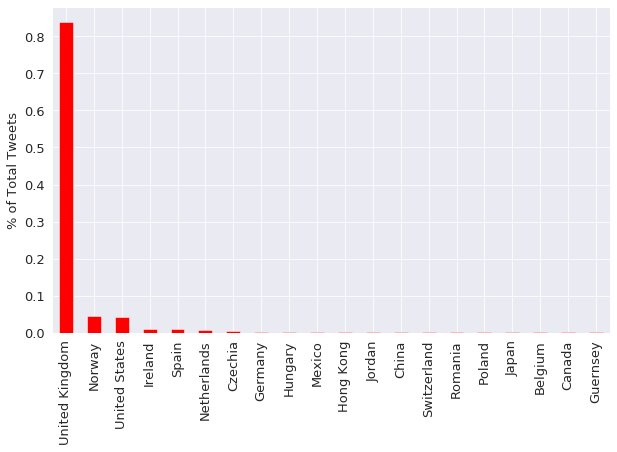

In [10]:
# plot histogram of tweets counts by country of origin
sns.set_style("darkgrid")
x = df_tweets_loc.country.value_counts(1).head(20)
x.plot(kind='bar',figsize=(10,6),fontsize=13,color='red')
plt.savefig('/content/drive/My Drive/Twitter_Project/tweets_by_country.png', bbox_inches='tight')
plt.ylabel('% of Total Tweets', fontsize=13);

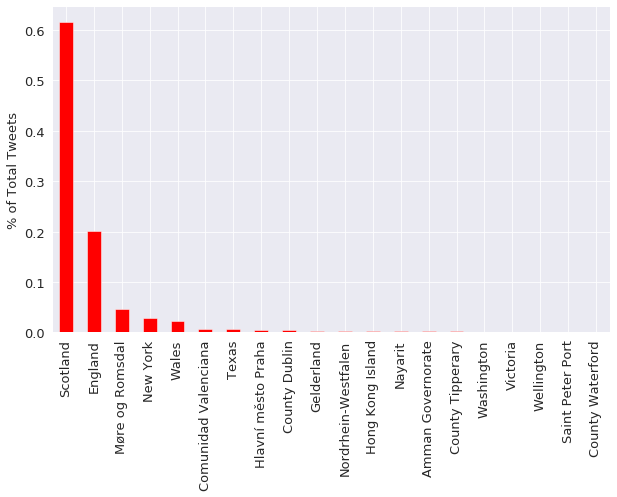

In [11]:
# plot histogram of tweets counts by nation/state of origin
sns.set_style("darkgrid")
x = df_tweets_loc.nation.value_counts(1).head(20)
x.plot(kind='bar',figsize=(10,6),fontsize=13,color='red')
plt.savefig('/content/drive/My Drive/Twitter_Project/tweets_by_nation.png', bbox_inches='tight')
plt.ylabel('% of Total Tweets', fontsize=13);

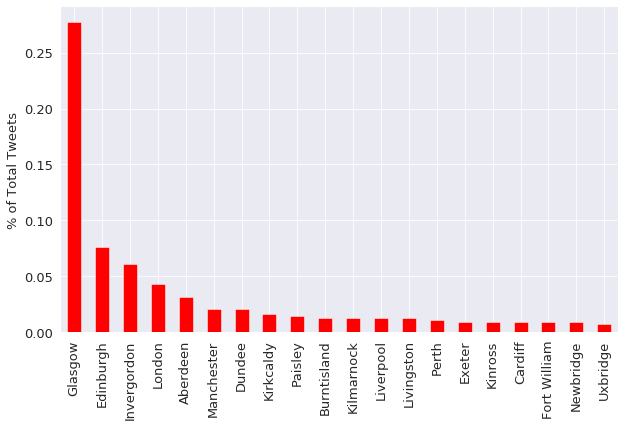

In [12]:
# plot histogram of tweets counts by city of origin
sns.set_style("darkgrid")
x = df_tweets_loc.city.value_counts(1).head(20)
x.plot(kind='bar',figsize=(10,6),fontsize=13,color='red')
plt.savefig('/content/drive/My Drive/Twitter_Project/tweets_by_city.png', bbox_inches='tight')
plt.ylabel('% of Total Tweets', fontsize=13);

As expected, most tweets come from Scotland and specifically, from Glasgow, a city known for its high percentage of pro-independence supporters. However, a good amount come from England. We'll look into sentiment differences between tweets and where they come from with the help of some maps.

Next we extract the total sentiment from each one of the UK cities by adding positives to negatives and the final number is a +/- indicator.

In [19]:
country = 'United Kingdom'

# Subset UK tweets only
df_tweets_loc_UK = df_tweets_loc.loc[(df_tweets_loc.country == country)]

# Check result

print('The dataframe has {} cities from {}.'.format(
        len(df_tweets_loc_UK['city'].unique()),
        df_tweets_loc_UK['country'].unique()
    )
)

The dataframe has 131 cities from ['United Kingdom'].


In [54]:
#----  Extract total sentiment per city -----#

# Copy original dataset
df_city_sentiment = df_tweets_loc_UK.copy

# Group by city
df_city_sentiment = df_tweets_loc_UK.groupby(['city'])['predictions'].value_counts().unstack().fillna(0.0).reset_index()

# Get total sentiment by adding positive and negative sentiments
df_city_sentiment['total_sentiment'] = -(df_city_sentiment[0])+df_city_sentiment[1] 

# Check result
df_city_sentiment[15:24]

predictions,city,0,1,total_sentiment
15,Bradford,1.0,0.0,-1.0
16,Bridge of Weir,1.0,0.0,-1.0
17,Bristol,2.0,0.0,-2.0
18,Buckie,1.0,0.0,-1.0
19,Burntisland,5.0,2.0,-3.0
20,Caernarfon,1.0,0.0,-1.0
21,Callander,1.0,1.0,0.0
22,Cambridge,2.0,0.0,-2.0
23,Cardiff,2.0,3.0,1.0


We're done calculating the total sentiment per city. Now the issue is that we have the location per tweet but not per city. So we'll quickly extract latitude and longitudes for each city using the `Nominatim` geocoder.

In [0]:
# Extract latitude and longitude of a city as a lists using Nominatim geocoder.

# Initialise empty list
lat = []
lon = []

# define instance of the geocoder
user_agent="uk_explorer"

# Loop to extract latitudes and longitudes
for place in df_city_sentiment['city']:
  
    address = place # force to str just in case
    geolocator = Nominatim(user_agent=user_agent)
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
      
    # append lat and lon to lists
    lat.append(latitude)
    lon.append(longitude)

In [0]:
# Append latitudes and longitudes to dataframe
df_city_sentiment['latitude'] = lat
df_city_sentiment['longitude'] = lon

In [70]:
# Check results
df_city_sentiment.head()

predictions,city,0,1,total_sentiment,latitude,longitude
0,Aberdeen,7.0,10.0,3.0,57.148243,-2.092809
1,Aberystwyth,2.0,0.0,-2.0,52.414311,-4.081685
2,Airdrie,2.0,1.0,-1.0,51.285970,-114.010620
3,Altrincham,1.0,0.0,-1.0,53.383966,-2.352546
4,Annan,1.0,1.0,0.0,54.988221,-3.260413


Now, let's examine the distribution of sentiment in our dataframe of cities' sentiment.

In [133]:
# Summary statistics
df_city_sentiment.total_sentiment.describe()

count    131.000000
mean      -0.709924
std        2.513008
min      -19.000000
25%       -1.000000
50%       -1.000000
75%        1.000000
max        4.000000
Name: total_sentiment, dtype: float64

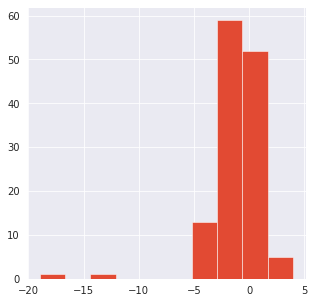

In [131]:
# Plot histogram of total sentiment
df_city_sentiment.total_sentiment.hist(figsize=(5,5));

From the histogram and summary statistics we can observe that the majority of values lie between `-5` and `5` overall sentiment slightly skewed towards the negative side. The average (median) sentiment is a negative sentiment (`-1`). We also have a couple of cities with a large value of total negative sentiment, compared to the rest of the cities in the dataframe. 

We'll now create a map to visualise the spatial distribution of cities in our dataframe across these negative and positive sentiment dimensions.

In [0]:
#--------- Temple to legend to a folium map using macros -----------------------#
# Adding a legend or color bar is only available for choroplet maps in folium #

##--source code: https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd -----#####

from branca.element import Template, MacroElement

# Add legend to folium map using macros

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend (draggable!)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>Negative</li>
    <li><span style='background:lightblue;opacity:0.7;'></span>Neutral</li>
    <li><span style='background:blue;opacity:0.7;'></span>Positive</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

Use `geopy` library to get the latitude and longitude values of the UK.

In [121]:
address = 'United Kingdom'

# set the user agent you want for the geolocator
geolocator = Nominatim(user_agent="uk_explorer")
location = geolocator.geocode(address)

# Save latitude
latitude_UK = location.latitude

# Save longitude
longitude_UK = location.longitude

print('The geograpical coordinates of the United Kingdom are {}, {}.'.format(latitude_UK, longitude_UK))

The geograpical coordinates of the United Kingdom are 54.7023545, -3.2765753.


In [127]:
#--------------------- Generate map of sentiment distribution ---------------------#

# create map
map_predictions = folium.Map(location=[latitude_UK, longitude_UK], zoom_start=5)

# add markers to the map
for lat, lon, city, label in zip(df_city_sentiment['latitude'], df_city_sentiment['longitude'], 
                                  df_city_sentiment['city'], df_city_sentiment['total_sentiment']
                                  ):
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=('City: ' + str(city).capitalize() + '<br>'
                 'Total sentiment: ' + str(label) + '<br>'
                 ),
        color='b',
        fill=True,
        # set color scheme for the labels
        fill_color= 'red' if label < -1 \
               else 'lightblue'if label < 1\
                else 'blue',
        fill_opacity=0.7).add_to(map_predictions)

# instantiate macro element
macro = MacroElement()

# call the template for the map legend
macro._template = Template(template)

# add legent
map_predictions.get_root().add_child(macro)

# save map
map_predictions.save("/content/drive/My Drive/Twitter_Project/twitter_uksentiment_map.html") 

# show map
map_predictions

As a reminder, the total sentiment we are using is obtained by summing up the positives and negatives for each city to come up with a final number.

We have set up a scale of colours where any sentiment below `-1` is marked as red and negative, between `-1` and `1` is light blue and neutral, and finally, above `1` is considered as positive and coloured in blue. 

Overall, it can be said that tweets from cities in Scotland have an overall more negative sentiment than those from England and Wales. We observe one city in Northern Ireland with overall neutral sentiment. The city with the highest negative sentiment overall (`-19`) is Glasgow, followed by Invergordon (`-13`).

Again, this does not mean that tweets from Scotland have a negative attitude towards Scottish Inpendence but rather the tweets carry a negative sentiment, a.k.a. angry tweets. 



Now, we'll create a heatmap, where we map every tweet in the dataset from their respective geolocation data to observe the density. 

In [0]:
# use the folium library to create all tweet origins in the dataset on map of UK
from IPython.display import IFrame
from IPython.display import HTML, display
import os

geo_data = 'http://geoportal1-ons.opendata.arcgis.com/datasets/01fd6b2d7600446d8af768005992f76a_4.geojson'

geoplots = []
for index, row in df_tweets_loc_UK[['latitude','longitude','predictions']].iterrows():
    geoplots.append([row['latitude'],row['longitude'],row['predictions']])

map_tweet_dense = folium.Map(location=[latitude_UK, longitude_UK], 
                 zoom_start=5) # for UK 

plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True).add_to(map_tweet_dense)

map_tweet_dense.choropleth(
    geo_data=geo_data,
    fill_color='red', 
    fill_opacity=0.1, 
    line_opacity=0.2,
    name='UK Cities')
    
map_tweet_dense.add_child(plugins.HeatMap(geoplots,
                            name='Twitter HeatMap',
                            radius=10,
                            max_zoom=1,
                            blur=10, 
                            max_val=3.0))

folium.TileLayer('cartodbpositron').add_to(map_tweet_dense)
folium.TileLayer('cartodbdark_matter').add_to(map_tweet_dense)
folium.TileLayer('Mapbox Control Room').add_to(map_tweet_dense)
folium.LayerControl().add_to(map_tweet_dense)

# save heatmap
map_tweet_dense.save("/content/drive/My Drive/Twitter_Project/twitter_uk_map.html") 

# Show heatmap
map_tweet_dense

Th heatmap shows a lot of tweets originate from high population density urban areas, as expected. These areas are Glasgow, Edinburgh, London, Liverpool, Manchester and Cardiff.

The map gives us a way to see where the tweets are coming from and the next step would be to map them according to their sentiment value for a better geo representation of sentiment.

We can also add a time dimension to the map to visualise tweets as they happen in a time series and in real time which would be a great tool for tracking a topic of interest for stakeholders involved. 

### 7.4 Conclusion and final toughts

We trained and selected a model that performed relatively well for a sentiment analysis model with an accuracy of 75%. But more can be done to improve our confidence in its perfomance.

For example, stakeholders maybe interested in the specific emotions towards Scottish Independence rather than the polarity itself. They may want to understand how people feel about the topic, or recognizing growing anger or fear associated with it. 

In this [paper](http://emnlp2014.org/papers/pdf/EMNLP2014127.pdf) researchers were able to train a model to learn from three types of emotion indicators for tweets: hashtags, hashtag patterns, and phrases for one of five emotions: Affection, anger/rage, fear/anxiety, joy or sadness/dissapointment. Their learned set of emotion indicators yielded a substantial improvement in the F-scores of classifiers, ranging from +%5 to +%18 over baseline classifiers. Training our classifiers with emotion phrases and their context would be very beneficial.

